In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

nb_bits = 1000             
fs = 1000                     
snr_db = 50                        
doppler_freq = 20                  
rice_k = 4                          
taps_delay = np.array([10, 10, 10, 10, 10])  
rice_gains_db = np.array([-6, -2, -1, -8, -9])
rayleigh_gains_db = np.array([-1, -2, -15, -8, -13])


In [46]:
# Generate random bits
bits = np.random.randint(0, 2, nb_bits)

# Group into pairs and map to QPSK
symbols = bits.reshape(-1, 2)
mapping = {
    (0, 0): 1+1j,
    (0, 1): -1+1j,
    (1, 0): 1-1j,
    (1, 1): -1-1j
}
qpsk_signal = np.array([mapping[tuple(b)] for b in symbols])


In [47]:
def apply_channel(signal, gains_db, channel_type='rayleigh', k=1):
    gains_lin = 10**(gains_db / 20) 
    h = []
    for gain in gains_lin:
        if channel_type == 'rayleigh':
            fading = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)
        elif channel_type == 'rice':
            v = np.sqrt(k / (k + 1))
            sigma = np.sqrt(1 / (2 * (k + 1)))
            fading = v + sigma * (np.random.randn() + 1j * np.random.randn())
        h.append(gain * fading)  
    return lfilter(h, [1.0], signal)


In [48]:
def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    return signal + noise


In [49]:
def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    return signal + noise


In [50]:
received_rice = apply_channel(qpsk_signal, rice_gains_db, channel_type='rice', k=rice_k)
received_rice = add_awgn(received_rice, snr_db)


In [51]:
received_rayleigh = apply_channel(qpsk_signal, rayleigh_gains_db, channel_type='rayleigh')
received_rayleigh = add_awgn(received_rayleigh, snr_db)


In [52]:
def power_dbm(signal):
    power_watts = np.abs(signal)**2
    power_dbm = 10 * np.log10(power_watts * 1000)  # 1 W = 30 dBm
    return power_dbm

rice_dbm = power_dbm(received_rice)
rayleigh_dbm = power_dbm(received_rayleigh)


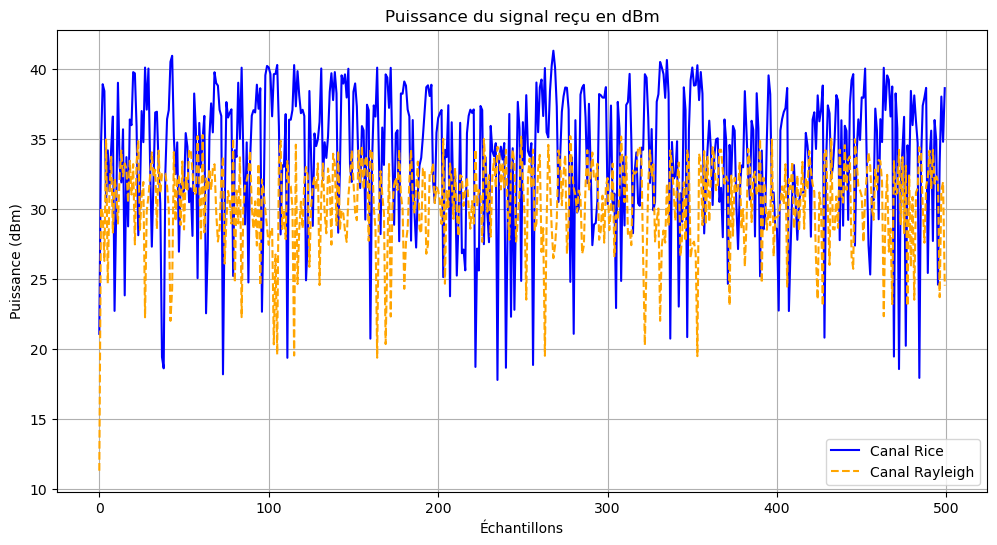

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(rice_dbm, label='Canal Rice', color='blue')
plt.plot(rayleigh_dbm, label='Canal Rayleigh', color='orange', linestyle='--')
plt.title("Puissance du signal reçu en dBm")
plt.xlabel("Échantillons")
plt.ylabel("Puissance (dBm)")
plt.legend()
plt.grid(True)
plt.show()
